<a href="https://colab.research.google.com/github/varvelac/medical-callback-data-analytics/blob/main/medical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using the below resource as a template.  I'm writing a new notebook using Churn Data**

https://www.kaggle.com/code/varvelac/comprehensive-data-exploration-with-python-f2a2a7/



This is where we import dependencies. these dependencies are python libraries. python libraries have shortcuts in them in the form of functions. instead of learning and writing the code to do an operation, you can access a method in the libraries.

# New Section

In [ ]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#sns.set_theme(style="whitegrid")
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder


you can see below that we use the pandas library's (but since we wrote "pandas as pd", we only have to type pd to reference the pandas library)  'read_csv()' method. so instead of having to go to college and learn how to write the function of reading a csv file, all we have to do is invoke this libraries pre-made function.  let's not re-invent the wheel.

In [ ]:
df = pd.read_csv('/content/aug-1-2022-jan-25-2023.csv')
df.columns

Index(['ID', 'Date of Birth', 'Test Type', 'Referral Date',
       'Ordering Last Name', 'Ordering First', 'Test Date', 'Test Status',
       'IV Status', 'Location Name', 'Unable to Schedule?',
       'Unable to Schedule Reason ', 'Incomplete Referral?',
       'Missing Information:', 'Primary Insurance'],
      dtype='object')

Let's seperate the dob and referral date into a date dataframe.
Let's seperate out some category columns that we will convert to numeric for ml training

In [ ]:
#not dropping the columns.  seperating to recombine
#df.drop(columns=['ID', 'Date of Birth', 'Referral Date', 'Ordering Last Name', 'Ordering First', 'Missing Information:', 'Unable to Schedule Reason ', 'Primary Insurance', 'Test Date'], axis=1, inplace=True)
df_numeric = df.loc[:, ['ID','Test Type', 'Test Status', 'IV Status', 'Location Name', 'Unable to Schedule?','Incomplete Referral?', 'Unable to Schedule Reason ']]
df_dates = df.loc[:, ['ID','Date of Birth', 'Referral Date']]

In [ ]:
#leaving here for reference
# print(pd.factorize(df_train['Test Status']))
# df_train["Test Status"] = pd.factorize(df_train["Test Status"])[0]
print(df_numeric["IV Status"].value_counts())

Pending- NEW Referral               2329
Complete                            2159
Denied                               114
Pending- Need additional info         90
Pending- Authorization Initiated      26
Pending- Hold IV                       4
Name: IV Status, dtype: int64


Lets convert the dob column to age.

In [ ]:
# Convert DOB column to datetime then to age
df_dates.dropna(subset=['Date of Birth', 'Referral Date'], inplace=True)
#df_dates = df_dates[df_dates['Date of Birth', 'Referral Date'] != 'Invalid']
df_dates['Referral Date'] = pd.to_datetime(df_dates['Referral Date'])
df_dates["Age"] = round((pd.datetime.now() - pd.to_datetime(df_dates["Date of Birth"])).dt.days/365)

df_dates['Referral Month'] = df_dates['Referral Date'].dt.month


df_dates.drop(columns=['Date of Birth'], axis=1, inplace=True)
df_dates.drop(columns=['Referral Date'], axis=1, inplace=True)
#the ID is messy, we just need to give it cleaner but just as arbitrary values
encoder = LabelEncoder()
df_dates['ID'] = encoder.fit_transform(df_dates['ID'])
df_dates.head()



,ID,Age,Referral Month
0,4723,31.0,1
1,4722,62.0,1
2,4721,34.0,1
3,4720,18.0,1
4,4719,81.0,1


In [ ]:
# unique_maps = {}
# for column in df_numeric.columns:
#     _, uniques = pd.factorize(df_numeric[column])
#     unique_maps[column] = uniques
#     df_numeric[column] = uniques.get_indexer(df_numeric[column])


# df_numeric = df_numeric.apply(lambda x: pd.factorize(x)[0],axis=1)
encoder = LabelEncoder()
unique_maps = {}
for column in df_numeric.columns:
    _, uniques = pd.factorize(df_numeric[column])
    unique_maps[column] = uniques
    df_numeric[column] = encoder.fit_transform(df_numeric[column])

df_numeric.head()




,ID,Test Type,Test Status,IV Status,Location Name,Unable to Schedule?,Incomplete Referral?,Unable to Schedule Reason
0,4723,4,5,4,5,1,2,17
1,4722,3,5,4,0,1,2,17
2,4721,11,5,4,3,1,2,17
3,4720,7,5,4,4,1,1,17
4,4719,4,5,4,5,1,2,17


Let's join the dataframes on ID.

In [ ]:
#print(df_numeric.apply(type))
#print(df_dates.apply(type))
df_dates['ID'] = df_dates['ID'].astype(int)
df_numeric['ID'] = df_numeric['ID'].astype(int)

merged_df = pd.merge(df_numeric, df_dates, on='ID')
merged_df.head()


,ID,Test Type,Test Status,IV Status,Location Name,Unable to Schedule?,Incomplete Referral?,Unable to Schedule Reason,Age,Referral Month
0,4723,4,5,4,5,1,2,17,31.0,1
1,4722,3,5,4,0,1,2,17,62.0,1
2,4721,11,5,4,3,1,2,17,34.0,1
3,4720,7,5,4,4,1,1,17,18.0,1
4,4719,4,5,4,5,1,2,17,81.0,1


- volume by test type
- what % of total orders were completed  -  2.4%
- of the order that were not completed due to unable to schedule - reason: unable to contact pt
- same but reason: patient refused
- highest volume ordering doctors (not interpreting doctor)
- highest volume by primary insurance

In [ ]:
print(merged_df['Unable to Schedule Reason '].value_counts(normalize=True).sort_index() )
print(np.array(unique_maps['Unable to Schedule Reason ']))

0     0.000212
1     0.000423
2     0.034505
3     0.001482
4     0.001058
5     0.104784
6     0.013760
7     0.000423
8     0.025402
9     0.000635
10    0.000423
11    0.055885
12    0.189246
13    0.001058
14    0.000847
15    0.003175
16    0.006139
17    0.560542
Name: Unable to Schedule Reason , dtype: float64
['OTHER: Entry error' 'INSURANCE: Denial' 'PATIENT: Refused study'
 'PATIENT: Unable to contact'
 'OTHER: Does not qualify - Missing documentation'
 'PATIENT: Do not contact to schedule'
 'REFERRAL: Physician cancelled order'
 'REFERRAL: Patient sent to another provider' 'PATIENT: Deceased'
 'PATIENT: Does not qualify for HST'
 'PATIENT: Unable to schedule delivery of device' 'Needed'
 'INSURANCE: Out of network'
 'REFERRAL: Patient does not clinically qualify for study'
 'INSURANCE: Deductible or financial  issue' 'PATIENT: Multiple NO SHOWS'
 'FINANCIAL: Financial hardship or payment issues']


[40, 1734, 534, 21, 1, 2393, 1]


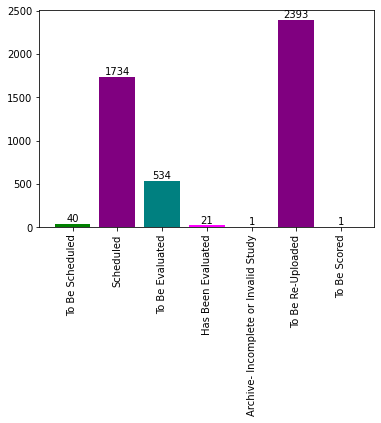

In [ ]:
#print(np.array(unique_maps['IV Status']))
distArrayVar = list(merged_df['Test Status'].value_counts().sort_index().values)
print(distArrayVar)

#print(distArrayVar)
height = distArrayVar
bars = np.array(unique_maps['Test Status'])
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['green', 'purple', 'teal', 'magenta', 'lime', 'purple', 'black'])
for i, v in enumerate(height):
    plt.text(x_pos[i]+0.0, v+0.01, str(v), ha = 'center', va = 'bottom')
# Create names on the x-axis
plt.xticks(x_pos, bars, rotation=90)



# Show graph
plt.show()
#

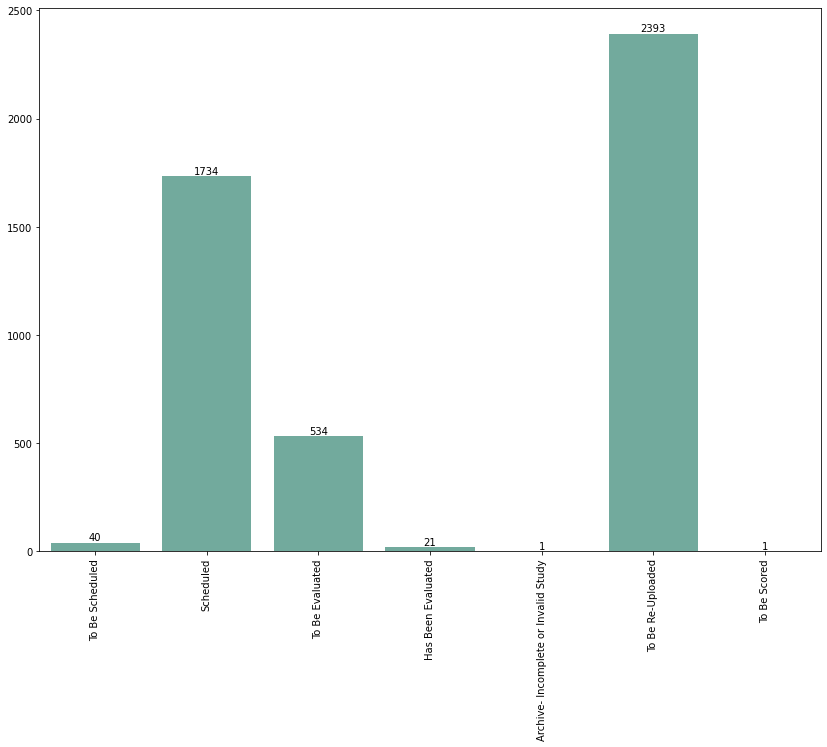

(array([4, 0, 1, 0, 0, 0, 0, 1, 0, 1]),
 array([1.0000e+00, 2.4020e+02, 4.7940e+02, 7.1860e+02, 9.5780e+02,
        1.1970e+03, 1.4362e+03, 1.6754e+03, 1.9146e+03, 2.1538e+03,
        2.3930e+03]))

In [ ]:
plt.figure(figsize=(14, 10))

# Reorder this data frame
#test = df.sort_values(['Test Status'], ascending=False).reset_index(drop=True)

# Make a barplot
x = list(merged_df['Test Status'].value_counts().sort_index().values)
y = np.array(unique_maps['Test Status'])
sns.barplot(
    x=y, 
    y= x, 
    data=merged_df, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
);

x_pos = np.arange(len(y))

for i, v in enumerate(height):
    plt.text(x_pos[i]+0.0, v+0.01, str(v), ha = 'center', va = 'bottom')
plt.xticks(x_pos, y, rotation=90)
plt.show()
np.histogram(x)

0    0.457028
1    0.024132
2    0.005504
3    0.000847
4    0.493014
5    0.019052
6    0.000423
Name: IV Status, dtype: float64


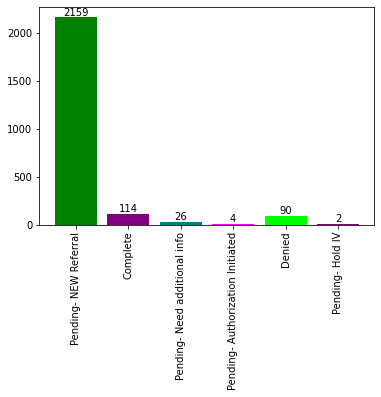

['Pending- NEW Referral' 'Complete' 'Pending- Need additional info'
 'Pending- Authorization Initiated' 'Denied' 'Pending- Hold IV']


In [ ]:

distArrayVar = list(merged_df['IV Status'].value_counts().sort_index())
print(merged_df['IV Status'].value_counts(normalize=True).sort_index() )
y = np.array(unique_maps['IV Status'])

highest_index = np.argmax(distArrayVar)
#distArrayVar = np.delete(distArrayVar, 0)
height = np.delete(distArrayVar, highest_index)#[3, 12, 5, 18, 45,60]
bars = y #np.delete(y, highest_index)
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['green', 'purple', 'teal', 'magenta', 'lime', 'purple', 'black'])
for i, v in enumerate(height):
    plt.text(x_pos[i]+0.0, v+0.01, str(v), ha = 'center', va = 'bottom')
# Create names on the x-axis
plt.xticks(x_pos, bars, rotation=90)

# Show graph
plt.show()
#

print(np.array(unique_maps['IV Status']))

here's another single column visualization.

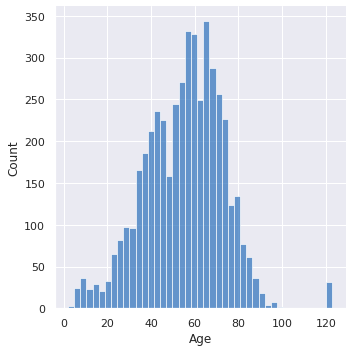

In [ ]:
sns.displot(merged_df['Age'])

In [ ]:
print("Skewness: %f" % merged_df['Test Type'].skew())
print("Kurtosis: %f" % merged_df['Test Type'].kurt())

Skewness: 0.385246
Kurtosis: -1.479339


Okay, we are starting to explore 2 column graphs.  for making the code more clean, I added to string variables, so i can switch them out on the fly without having to retype a bunchg of stuff.

we use the pandas library method concat.  "Concatenate pandas objects along a particular axis."  not super sure what this means.  I'm sure it's not like concat in javascript.

either way, we save the product of pd.concat() in the variable data.

the product of pd.concat is an Object with a a plot property.  That plot property has a method called scatter.  It's safe to assume that invoking this method will produce a scatter plot.

this method takes 3 arguments.  we are passing the our x and y variables along with another parameter that is used to limit the y axis

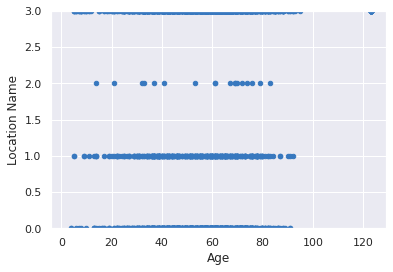

In [ ]:
varX = 'Age'
varY = 'Location Name'
data = pd.concat([merged_df[varY], merged_df[varX]], axis=1)
data.plot.scatter(x=varX, y=varY, ylim=(0,3));

This is just a duplicate of the above

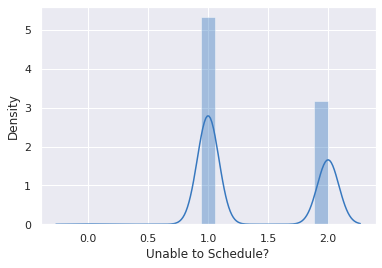

In [ ]:
sns.distplot(df_numeric['Unable to Schedule?']);

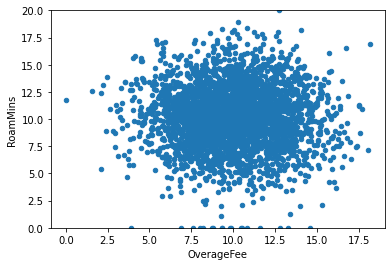

In [ ]:
varX = 'OverageFee'
varY = 'RoamMins'
data = pd.concat([df_numeric[varY], df_numeric[varX]], axis=1)
data.plot.scatter(x=varX, y=varY, ylim=(0,20));

I'm just expirementing with more visualizations in the Seaborn library.
One column I'm using here is 'Churn'.  it's a boolean in the form of an interger.  0 for false and 1 for true.

I'm wanting to find a type of graph that will plot this binary in a meaningful way.

I suspect that the more customer service calls a person makes, the greater the likelyhood they will Churn or cancel their plan.

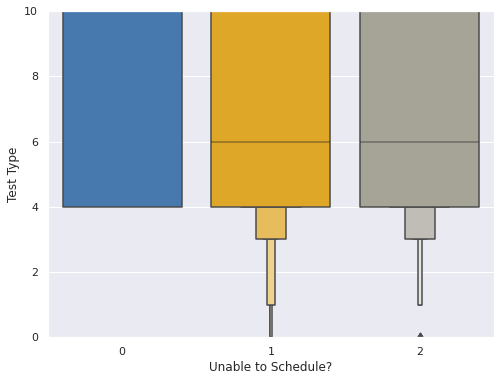

In [ ]:
varX = 'Unable to Schedule?'
varY = 'Test Type'
data = pd.concat([merged_df[varY], merged_df[varX]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxenplot(x=varX, y=varY, data=data)
fig.axis(ymin=0, ymax=10);

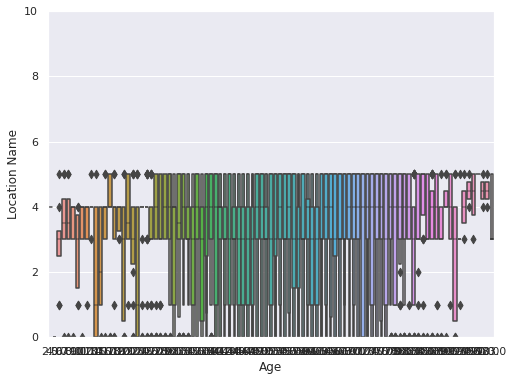

In [ ]:
varX = 'Age'
varY = 'Location Name'
data = pd.concat([merged_df[varY], merged_df[varX]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxenplot(x=varX, y=varY, data=data)
fig.axis(ymin=0, ymax=10);
plt.xticks(rotation=0);

This is what I heard is called a plasma soup.  This is apart of the Seaborn library.  This looks like the best way to get an overall view of the data and see which columns correlate.  Looks like Churn and Customer Service Calls have a relationship.  We also saw that above.


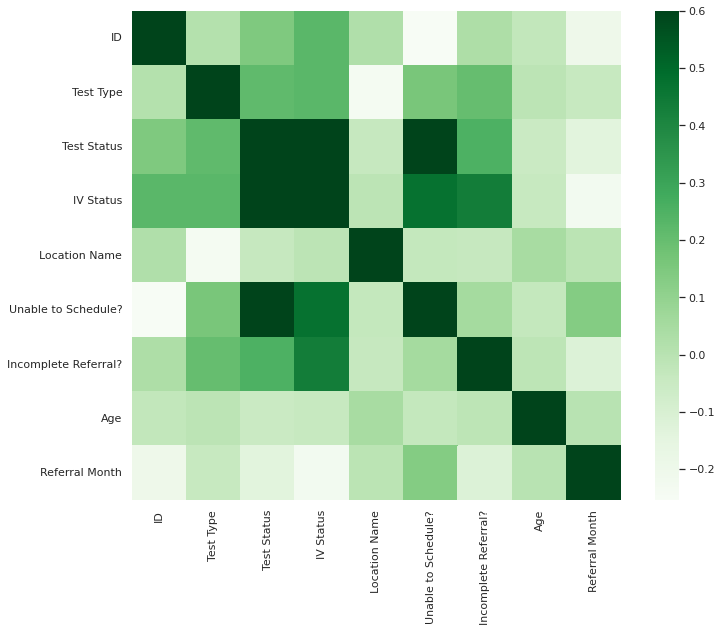

In [ ]:
corrmat = merged_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.6,cmap="Greens", square=True);

I'm not sure what Seaborns .set() does.  
next we define the columns we want to work with
then we invoke Seaborns pairplot function which takes 2 arguements.

Not sure why they use the MathLabLib library(*MatLabLib as plt) .show(). I don't know what it does.  

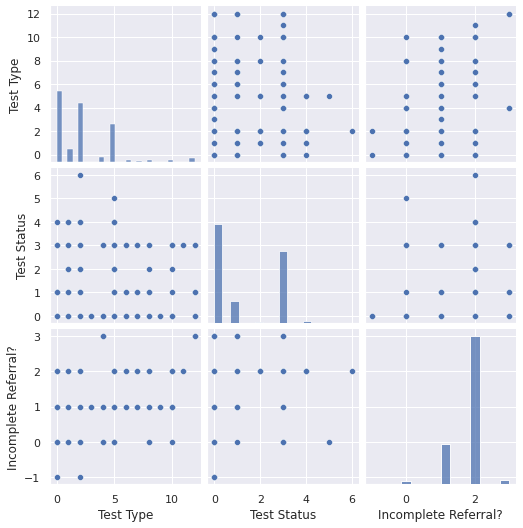

In [ ]:
#scatterplot
sns.set()
cols = ['Test Type', 'Test Status', 'Incomplete Referral?']
sns.pairplot(df_numeric[cols], size = 2.5)
#plt.show();